# Albert bimonthly approach
### Testing the implementation of alberts LCCS approach
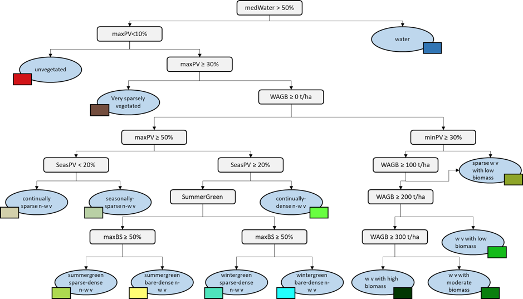


Current workflow
- For each pixel, the median of all good-quality WofS, PV, NPV, and BS estimates were calculated. 
(calculate the median for a 2 month period)
- The FC and WofS data sets were made internally consistent by allowing for the fractional cover of water (misclassified as BS in the FC product) and ensuring the total of all fractions amounts to 100%.
- Next, for each year, summary metrics were calculated from the bi-monthly median values. Specifically, for each year were calculated:
(group by min/max for annual year)
1.	MedWater - Median bi-monthly water occurrence (0-100%)
2.	MinPV - Minimum bimonthly PV fraction (0-100%)
3.	MaxPV - Maximum bi-monthly PV fraction (0-100%)
4.	MaxBS - Maximum bi-monthly BS fraction (0-100%)
5.	tmaxPV - Bi-monthly period corresponding to maxPV (1-6)

- The degree to which wetlands were inundated during most of the year (medWater) indicates wetland health
- Changes in the minimum PV (minPV) indicate the condition of the persistent vegetation component (typically the woody component)
- The achieved maximum PV (maxPV) indicates the quality of growing conditions for the ephemeral vegetation component (e.g. achieved herb cover, crop density and pasture biomass)
- The maximum BS (maxBS) indicates the degree to which the soil was left exposed to wind and water erosion and can be used as a generic indicator of rangeland health.

### Current problem
- NPV is too much on the beaches, saltflats, mudflats
- however use of NPV is very good for interior and arid regions

### Potential solutions
- use first 2 levels of albers approach
- biomonthly instead of monthly but keep FCsummary approach?


In [1]:
import os, sys, copy
import yaml
import numpy as np
import xarray as xr
import pickle

from itertools import groupby
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import datacube
from datacube.storage import masking
from datacube.virtual import catalog_from_file
dc = datacube.Datacube()

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


In [2]:
# AWS or Gadi
service = '/home/jovyan/development/'
# service = '/g/data/u46/users/bt2744/work/code/'

sys.path.append(str(service)+"dea-notebooks/Scripts")
from dea_classificationtools import sklearn_unflatten
from dea_classificationtools import sklearn_flatten

sys.path.append(os.path.abspath(str(service)+"livingearth_australia/le_plugins"))

In [24]:
# loading extents from yaml Dan prepared, just change site_name to tile interested in from our 16 test sites
yaml_sites_file = os.path.abspath(str(service)+"chris_leaust_testing/notebooks/misc/au_test_sites.yaml")

with open(yaml_sites_file, "r") as f:
    site_config = yaml.safe_load(f)

site_name = "Little Brisbane"
extent_x = [site_config[site_name]["min_x"],
            site_config[site_name]["max_x"]]
extent_y = [site_config[site_name]["min_y"],
            site_config[site_name]["max_y"]]

crs = "EPSG:3577"
res = (-25, 25)
time = ("2015-01-01", "2015-12-31")
query =({'time': time,
             'x':extent_x,
            'y':extent_y,
            'crs':crs,
            'resolution':res})

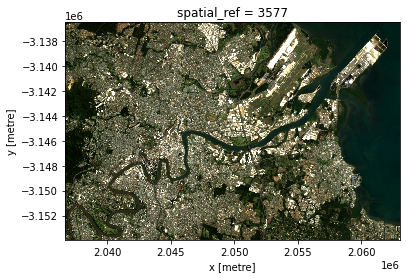

In [25]:
# Load Landsat
geomedian = dc.load(product="ls8_nbart_geomedian_annual", **query)
geomedian = masking.mask_invalid_data(geomedian).squeeze().drop('time')
geomedian[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)

In [26]:
# datacube functions to load in a virtual product from recipe
catalog = catalog_from_file(service+'chris_leaust_testing/notebooks/misc/virtual_product_cat.yaml')

#### making albert products

##### first, correct all the data (FC and water)

In [27]:
# load fc wofs mask (already masked out by water flag from wofs as nan values in vp)
product = catalog['ls_fc_wofs_masked']
ls_fc_wofs_masked = product.load(dc, **query)

# add water (no masking applied here, just raw wofs, so no nans at present)
product = catalog['wofs_daily']
wofs = product.load(dc, **query)
ls_fc_wofs_masked['water'] = wofs.water

In [28]:
## basically first step is to get good data for FC observations ##
# change of name so works with consecutive count function
data = ls_fc_wofs_masked
# mask_invalid_data used here as some of the FC fractions may contain -ve values so this makes sure everything goes from 0-100%
# doesn't change anything for water dataset (as no nans in product at present)
data_nan = masking.mask_invalid_data(data)

In [29]:
# Create water and low-quality fc masks
# create dataset no water present: water (0) and no water (1) (128 clear and wet; 132 clear and wet and sea)
# invert used here otherwise would be water (1) and no water (0)
no_water = np.invert((data['water'] == 128) | (data['water'] == 132))

# where uncertainty error of pixel is high (i.e. > 30) and no water is present (1)
# this is to remove bad terrestrial data that we not picked up by the water mask of the vp
high_ue_no_water = (data['UE'] > 30) & no_water

# Set to null areas with high UE, but no water
data_nan = data_nan.where(np.invert(high_ue_no_water))

In [30]:
# Don't need UE anymore, done its job
data_nan = data_nan.drop("UE")

# Where there's water, set PV to 0
data_nan['PV'] = data_nan.PV.where(no_water, 0)
data_nan['NPV'] = data_nan.NPV.where(no_water, 0)

# Where there's water, set BS to 0
data_nan['BS'] = data_nan.BS.where(no_water, 0)

# Where there's water, set water to 1
# invert no water (1) to water (could have mad a water mask before to stop inverting things, but this does the job for now)
water = np.invert(no_water)
# Where there's no water on our data_nan product set water to 0
data_nan['water'] = data_nan.water.where(water, 0)
# Where there's values for water that are 0, keep, otherwise all other values make 1
data_nan['water'] = data_nan.water.where(data_nan['water'] == 0, 1)

# now mask out nan values of water using FC
PV = data_nan.PV.isnull()
data_nan = data_nan.where(np.invert(PV))

##### second, get bimonthly medians and calculate summary metrics

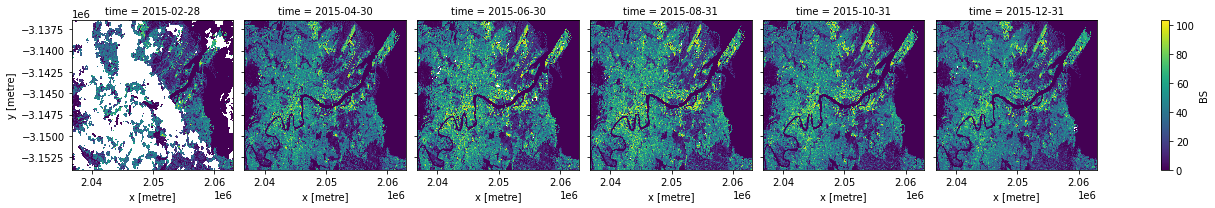

In [38]:
# Resample to combine each 2 months of data into a median composite
data_bimonthly = data_nan.resample(time='2m', closed='left').median()
data_bimonthly.BS.plot(col='time', col_wrap=6)

In [51]:
# Calculate summary bimonthly metrics
medWater = data_bimonthly.water.median(dim='time')
minPV = data_bimonthly.PV.min(dim='time')
maxPV = data_bimonthly.PV.max(dim='time')
minBS = data_bimonthly.BS.min(dim='time')
maxBS = data_bimonthly.BS.max(dim='time')


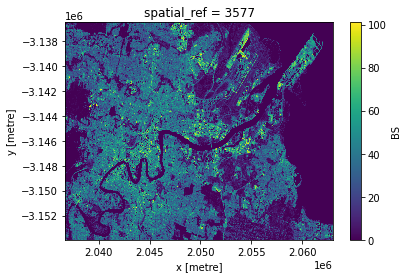

In [52]:
minBS.plot()

##### thrid, implement decision tree structure (image at start of nb)

In [33]:
level1 = np.zeros_like(medWater)
level2 = np.zeros_like(medWater)
level3 = np.zeros_like(medWater)
classification = np.zeros_like(medWater)

# decision tree conditions
level1 = np.where(medWater.values > 0.5, 1, 0)
level2 = np.where(maxPV.values < 10, 1, 0)
level3 = np.where(maxPV.values >= 30, 1, 0)

# end class outputs
# water
classification[(level1 == 1)] = 111
# unvegetated
classification[(level1 == 0) & (level2 == 1)] = 222
# very sparse vegetation
classification[(level1 == 0) & (level2 == 0) & (level3 == 0)] = 333
# vegetated
classification[(level1 == 0) & (level2 == 0) & (level3 == 1)] = 444

classification_xr = xr.DataArray(classification, coords=medWater.coords, dims=medWater.dims)

/env/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/env/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/env/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':


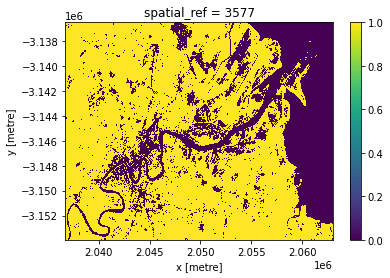

In [49]:
level2_xr = xr.DataArray(level2, coords=medWater.coords, dims=medWater.dims)
level3_xr = xr.DataArray(level3, coords=medWater.coords, dims=medWater.dims)
level3_xr.plot()

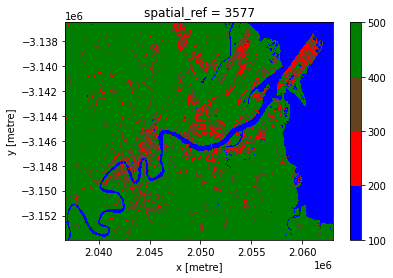

In [34]:
# output figure as per alberts colours in decision tree
# water(blue), unvegetated(red), very sparse vegetation(brown), vegetated(green)
col=["#0000FF", "#FF0000", "#654321", "#008000"]
classification_xr.plot(levels=5, colors=col)

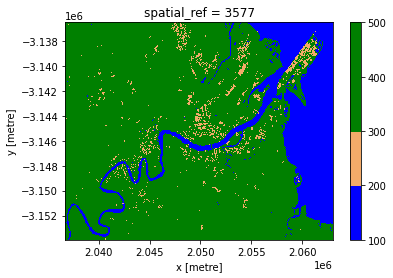

In [35]:
# output figure as per LCCS (veg/nonveg/water)
LCCScol=["#0000FF", "#F3AB69", "#008000", "#008000"]
classification_xr.plot(levels=5, colors=LCCScol)

In [36]:
# make binary veg/nonveg output, putting sparse vegetation (333) into non veg
bimonthly_sparseintobare = copy.deepcopy(classification_xr)
bimonthly_sparseintobare.values = np.where((classification_xr >= 444), 1, 0)

# make binary veg/nonveg output, putting sparse vegetation (333) into veg
bimonthly_sparseintoveg = copy.deepcopy(classification_xr)
bimonthly_sparseintoveg.values = np.where((classification_xr >= 333), 1, 0)

### old code below this point

#### making fc_veg product

In [16]:
data = ls_fc_wofs_masked

def consecutive_count_veg(tv_numpy, consecutive_numpy, required_consecutive, consec_msk_val=1):
    '''
    function to get consective count of veg (1) for each pixel across the time series

    :param numpy.array tv_numpy: 3-D array of tv[z,y,x]
    :param numpy.array consecutive_numpy: bool output array for veg (1) and non veg (0)
    :param float required_consecutive: how many consectutive 1's to be classified as veg?
    :param float consec_msk_val: what value to calculcate consectutives on
           default is veg (1)     
    '''

    for y in range(tv_numpy.shape[1]):
        for x in range(tv_numpy.shape[2]):
            # If all the values are nan then just set output to nan and carry on
            pixel = tv_numpy[:,y,x]

            if np.all(np.isnan(pixel)):
                consecutive_numpy[y,x] = np.nan
                continue            

            # Get counts of consecutive veg classifications
            counts = [len(list(group)) for label, group in groupby(pixel[(~np.isnan(pixel))]) if label == 1]

            if not counts:
                consecutive_numpy[y,x] = 0
            elif max(counts) >= required_consecutive:
                consecutive_numpy[y,x] = 1
            else:
                consecutive_numpy[y,x] = 0

    return consecutive_numpy

def consecutive_count_nonveg(tv_numpy, consecutive_numpy, required_consecutive, consec_msk_val=1):
    '''
    function to get consective count of non veg (0) for each pixel across the time series

    :param numpy.array tv_numpy: 3-D array of tv[z,y,x]
    :param numpy.array consecutive_numpy: bool output array for veg (1) and non veg (0)
    :param float required_consecutive: how many consectutive 0's to be classified as non veg?
    :param float consec_msk_val: what value to calculcate consectutives on
           default is non veg (0)     
    '''

    for y in range(tv_numpy.shape[1]):
        for x in range(tv_numpy.shape[2]):
            # If all the values are nan then just set output to nan and carry on
            pixel = tv_numpy[:,y,x]

            if np.all(np.isnan(pixel)):
                consecutive_numpy[y,x] = np.nan
                continue            

            # Get counts of consecutive non veg classifications (hence label == 0)
            counts = [len(list(group)) for label, group in groupby(pixel[(~np.isnan(pixel))]) if label == 0]

            # Inversed values from consecutive_count_veg to make non veg
            if not counts:
                consecutive_numpy[y,x] = 1
            elif max(counts) >= required_consecutive:
                consecutive_numpy[y,x] = 0
            else:
                consecutive_numpy[y,x] = 1

    return consecutive_numpy

data_nan = masking.mask_invalid_data(data)

# Create water and low-quality fc masks
no_water = np.invert( (data['water'] == 128) | (data['water'] == 132) )
high_ue = (data['UE'] > 30) & no_water

# Set to null areas with high UE, but no water
data_nan = data_nan.where(np.invert(high_ue))

# Don't need this anymore
data_nan = data_nan.drop("UE")
del high_ue

# Where there's water, set PV to 0
data_nan['PV'] = data_nan.PV.where(no_water, 0)
data_nan['NPV'] = data_nan.NPV.where(no_water, 0)

# Where there's water, set BS to 100
data_nan['BS'] = data_nan.BS.where(no_water, 100)

# Don't need this anymore
data_nan = data_nan.drop("water")
del no_water

data_month = data_nan.groupby('time.month').median(dim='time')    
data_bimonthly = data_nan.resample(time='2m', closed='left').median()

# Create mask where PV > BS
PV_dominant = data_month['PV'] > data_month['BS']
PV_dominant_nan = PV_dominant.where((data_month['PV'] >= 0) & (data_month['BS'] >= 0))

# Create mask where NPV > BS
NPV_dominant = data_month['NPV'] > data_month['BS']
NPV_dominant_nan = NPV_dominant.where((data_month['NPV'] >= 0) & (data_month['BS'] >= 0))

# Veg where PV or NPV are greater than BS
tv_mask = (PV_dominant_nan + NPV_dominant_nan)

# Make values of 2 == 1 (end result in binary veg mask)
tv_mask_drop = np.where(tv_mask == 2, 1, tv_mask)
tv_mask_xr = xr.DataArray(tv_mask_drop, coords=tv_mask.coords, dims=tv_mask.dims)

##### veg #####
# Executing consecutive_count function #
# veg and non veg = 2 consecutive months
required_consecutive = 2

# Pull tv as numpy array
tv_numpy = tv_mask_xr.values

# Set up array for output (faster to pre-allocate for numba).
# Needs to be float32 for NaN
consecutive_numpy = np.empty((tv_numpy.shape[1], tv_numpy.shape[2]), dtype=np.float32)

# For veg - run function to get array of with 1 where number of consecutive values for 
# different dates is >= required_consecutive
consecutive_numpy_veg = consecutive_count_veg(tv_numpy, consecutive_numpy, required_consecutive)

# Reduce original array to 2D
# using max here but not important as we just want to use shape/attributes
tv_reduce = tv_mask.max(dim='month')

# Create new data array with sampe dimensions as original
tv_summary_veg = xr.DataArray(consecutive_numpy_veg, coords=tv_reduce.coords, dims=tv_reduce.dims)  

##### non veg #####
# Executing consecutive_count function #
# veg and non veg = 2 consecutive months
required_consecutive = 2        

# Pull tv as numpy array
tv_numpy = tv_mask_xr.values        

# Set up array for output (faster to pre-allocate for numba).
# Needs to be float32 for NaN
consecutive_numpy = np.empty((tv_numpy.shape[1], tv_numpy.shape[2]), dtype=np.float32)

# For non veg - run function to get array of with 0 where number of consecutive values for 
# different dates is >= required_consecutive
consecutive_numpy_nonveg = consecutive_count_nonveg(tv_numpy, consecutive_numpy, required_consecutive)

# Reduce original array to 2D
# using max here but not important as we just want to use shape/attributes
tv_reduce = tv_mask.max(dim='month')

# Create new data array with sampe dimensions as original
tv_summary_nonveg = xr.DataArray(consecutive_numpy_nonveg, coords=tv_reduce.coords, dims=tv_reduce.dims)

## Combine veg and non veg masks (to ensure no data is correctly identified)
tv_combine = tv_summary_veg + tv_summary_nonveg

# Make values of 2 == 1 (end result in binary veg mask)
tv_combine_drop = np.where(tv_combine == 2, 1, tv_combine)

# Create new data array with sampe dimensions as original
tv_summary = xr.DataArray(tv_combine_drop, coords=tv_reduce.coords, dims=tv_reduce.dims)

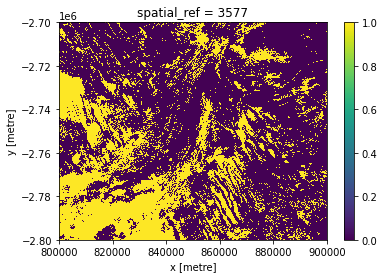

In [17]:
# # Plotting clear water observations
# # Mask where clear water was observed in WOfS (128: clear and wet, 132: clear, wet & sea)
# clearwater = ls_fc_wofs_masked.where(((ls_fc_wofs_masked['water'] == 128) | (ls_fc_wofs_masked['water'] == 132)), 1)
# clearwater.water.plot(col='time', col_wrap=7)

# # Plotting raw FC observations (masked with clear water observations)
# ls_fc_wofs_masked.BS.plot(col='time', col_wrap=7)


# # this is where FC all observations have been correct for water (i.e. BS == 100) and low quality (UE > 30)
# data_nan.NPV.plot(col='time', col_wrap=7)

# # monthly FC data (median), corrected for water (i.e. BS == 100) and low quality (UE > 30)
# data_month.NPV.plot(col='month', col_wrap=4)

# # where PV > BS and a real value
# PV_dominant_nan.plot(col='month', col_wrap=4)

# # where NPV > BS and a real value
# NPV_dominant_nan.plot(col='month', col_wrap=4)

# # combined PV_dominant_nan and NPV_dominant_nan
# tv_mask_xr.plot(col='month', col_wrap=4)

# consecutive count function for veg
tv_summary_veg.plot()

# # consecutive count function for non veg
# tv_summary_nonveg.plot()

#### making wofs_mask product

In [18]:
wofs_ann = dc.load(product="wofs_annual_summary", measurements=["frequency"], **query)
wofs_mask = 1-((wofs_ann["frequency"] >= 0.2)).squeeze().drop('time')

#### making si5 product


In [19]:
# load best pixel geomedian
product = catalog['best_pixel_gm']
best_pixel_gm = product.load(dc, **query)

In [20]:
best_pixel_gm['si5'] = ((best_pixel_gm['blue']*best_pixel_gm['red'])/best_pixel_gm['green']).drop('time').squeeze()
si5 = best_pixel_gm.si5
si5.values = np.where(si5 < 1500, 1, 0)

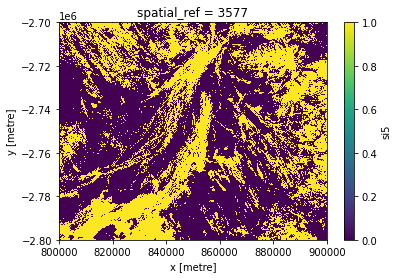

In [21]:
si5.plot()

#### display input for vegetat_veg_cat

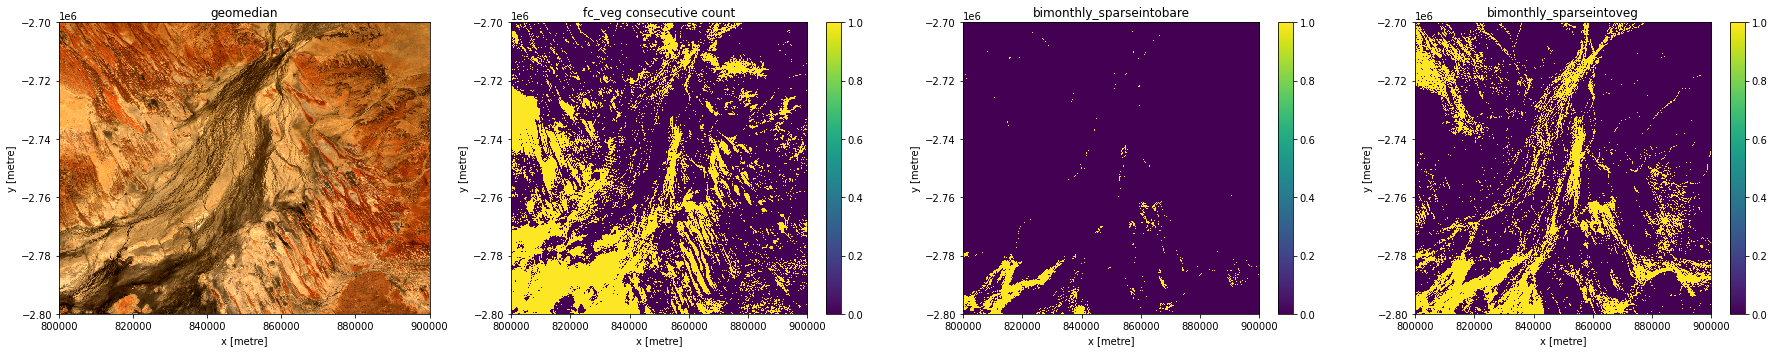

In [22]:
plt.figure(figsize=(25,5))
gs = gridspec.GridSpec(1,4)

ax1=plt.subplot(gs[0,0])
geomedian[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)
ax1.set_title('geomedian')

ax2=plt.subplot(gs[0,1])
tv_summary.plot.imshow()
ax2.set_title('fc_veg consecutive count')

ax3=plt.subplot(gs[0,2])
bimonthly_sparseintobare.plot.imshow()
ax3.set_title('bimonthly_sparseintobare')

ax4=plt.subplot(gs[0,3])
bimonthly_sparseintoveg.plot.imshow()
ax4.set_title('bimonthly_sparseintoveg')

plt.tight_layout()
plt.show()

#### display output for vegetat_veg_cat

In [23]:
vegetat_veg_cat_current = tv_summary * wofs_mask * si5
vegetat_veg_cat_bimonthly_sparseintobare = bimonthly_sparseintobare
vegetat_veg_cat_bimonthly_sparseintobare_with_si5 = bimonthly_sparseintobare * si5

vegetat_veg_cat_bimonthly_sparseintoveg = bimonthly_sparseintoveg
vegetat_veg_cat_bimonthly_sparseintoveg_with_si5 = bimonthly_sparseintoveg * si5

plt.figure(figsize=(25,10))
gs = gridspec.GridSpec(2,3)

ax1=plt.subplot(gs[0,0])
geomedian[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)
ax1.set_title('geomedian')

ax2=plt.subplot(gs[1,0])
vegetat_veg_cat_current.plot.imshow()
ax2.set_title('vegetat_veg_cat_current')

ax3=plt.subplot(gs[0,1])
vegetat_veg_cat_bimonthly_sparseintobare.plot.imshow()
ax3.set_title('vegetat_veg_cat_bimonthly_sparseintobare')

ax4=plt.subplot(gs[1,1])
vegetat_veg_cat_bimonthly_sparseintobare_with_si5.plot.imshow()
ax4.set_title('vegetat_veg_cat_bimonthly_sparseintobare_with_si5')

ax5=plt.subplot(gs[0,2])
vegetat_veg_cat_bimonthly_sparseintoveg.plot.imshow()
ax5.set_title('vegetat_veg_cat_bimonthly_sparseintoveg')

ax6=plt.subplot(gs[1,2])
vegetat_veg_cat_bimonthly_sparseintoveg_with_si5.plot.imshow()
ax6.set_title('vegetat_veg_cat_bimonthly_sparseintoveg_with_si5')

plt.tight_layout()
plt.show()